In [1]:
%pip install deap


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


**Zakharov Denis J4232c**

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/issue.svg">
>   <img alt="Issue" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/issue.svg">
> </picture><br>
>
> **Issue**
> 
>  The goal is to train evolutoinary algorithm to solve classic optimization function. The function is > **Rastrigin** function, but it is reversed and shifted.
> The maximum value that you can achieve is 10 and this is your goal!

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/info.svg">
>   <img alt="Info" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/info.svg">
> </picture><br>
>
> Syllabus
> 
> - [Seminar Example](https://datalore.jetbrains.com/notebook/RemqSkuJwmr1PM4Gc3cBqB/s2C59lbIA1bf9li6Z4fkgh#qmz2WjeXhkzxts25PTFY1k)
> - [Assignment Modification](https://datalore.jetbrains.com/notebook/RemqSkuJwmr1PM4Gc3cBqB/s2C59lbIA1bf9li6Z4fkgh#85Auew5g6rQ2RfZc8MbAaq)

# Seminar Example

In [2]:
import math
from multiprocessing import Pool

import numpy as np
import numpy.random as rnd

import deap
from deap import tools, base, creator, algorithms

import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [3]:
# Shifted Rastrigin function

noise = rnd.random(1000)

def rastrigin(individual):
    individual = individual + noise[0:len(individual)]
    n = len(individual)

    pi = math.pi
    dn = 1.0 / n
    a = 10.0
    b = 0.2
    c = 2 * pi
    s1 = 0.0
    s2 = 0.0
    for i in range(n):
        s1 += individual[i] * individual[i]
        s2 += np.cos(c*individual[i])
    s1 = -a * math.exp(-b*math.sqrt(dn*s1))
    s2 = -math.exp(dn*s2)
    result = s1+s2 + a + math.exp(1)
    result = -result
    result = result + a
    result = math.fabs(result)
    return result

In [4]:
noise.max()

0.99773654076527

In [5]:
solution = [0 for _ in range(20)]
rastrigin(solution)

7.37196488580188

In [6]:
creator.create("BaseFitness", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.BaseFitness)

In [7]:
def mutation(individual):
    n = len(individual)
    for i in range(n):
        if rnd.random() < n * 0.15:
            individual[i] += rnd.normal(0.0, 0.2)
            individual[i] = np.clip(individual[i], -5, 5)
    return individual,

In [8]:
class SimpleGAExperiment:
    def factory(self):
        return rnd.random(self.dimension) * 10 - 5 # random range from -5 to 5

    def __init__(self, function, dimension, pop_size, iterations):
        self.pop_size = pop_size
        self.iterations = iterations
        self.mut_prob = 0.6
        self.cross_prob = 0.3

        self.function = function
        self.dimension = dimension

        # self.pool = Pool(5)
        self.engine = base.Toolbox()
        # self.engine.register("map", self.pool.map)
        self.engine.register("map", map)
        self.engine.register("individual", tools.initIterate, creator.Individual, self.factory)
        self.engine.register("population", tools.initRepeat, list, self.engine.individual, self.pop_size)
        self.engine.register("mate", tools.cxOnePoint)
        self.engine.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.2)
        # self.engine.register("mutate", mutation)
        self.engine.register("select", tools.selTournament, tournsize=4)
        # self.engine.register("select", tools.selRoulette)
        self.engine.register("evaluate", self.function)


    def run(self):
        pop = self.engine.population()
        hof = tools.HallOfFame(3, np.array_equal)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, log = algorithms.eaMuPlusLambda(pop, self.engine, mu=self.pop_size, lambda_=int(self.pop_size*0.8), cxpb=self.cross_prob, mutpb=self.mut_prob,
                                  ngen=self.iterations,
                                  stats=stats, halloffame=hof, verbose=True)
        print("Best = {}".format(hof[0]))
        print("Best fit = {}".format(hof[0].fitness.values[0]))
        return log

In [9]:
def function(x):
    res = rastrigin(x)
    return res,

dimension = 100 # set it to 100
pop_size = 100 # lets say max is 100
iterations = 5000 # lets say max is 5000
scenario = SimpleGAExperiment(function, dimension, pop_size, iterations)

In [10]:
def read_log(log):
    avg_list = list()
    std_list = list()
    min_list = list()
    max_list = list()
    gen_list = list()
    for g in log:
        avg_list.append(g['avg'])
        std_list.append(g['std'])
        min_list.append(g['min'])
        max_list.append(g['max'])
        gen_list.append(g['gen'])
    return np.array(gen_list), np.array(avg_list), np.array(std_list), np.array(max_list), np.array(min_list)

def draw_log(log):
    gen_list, avg_list, std_list, max_list, min_list = read_log(log)
    plt.plot(gen_list, avg_list, label="avg")
    plt.plot(gen_list, min_list, label="min")
    plt.plot(gen_list, max_list, label="max")
    plt.fill_between(gen_list, avg_list-std_list, avg_list+std_list, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

def draw_logs(log1, log2, lab1, lab2):
    gen1, avg1, std1, max1, min1 = read_log(log1)
    gen2, avg2, std2, max2, min2 = read_log(log2)
    plt.plot(gen1, avg1, label=lab1, color="blue")
    plt.plot(gen1, max1, label="{}_max".format(lab1), color="blue", linewidth=2)
    plt.fill_between(gen1, avg1 - std1, avg1 + std1, alpha=0.2, color="blue")
    plt.plot(gen2, avg2, label=lab2, color="orange")
    plt.plot(gen2, max2, label="{}_max".format(lab2), color="orange", linewidth=2)
    plt.fill_between(gen2, avg2 - std2, avg2 + std2, alpha=0.2, color="orange")
    plt.legend()
    plt.tight_layout()
    plt.show()

gen	nevals	avg    	std     	min    	max    
0  	100   	3.84794	0.179819	3.34786	4.36544
1  	74    	4.02145	0.135899	3.76604	4.36544
2  	72    	4.14229	0.102311	3.92401	4.36544
3  	75    	4.27562	0.0887505	4.09402	4.56596
4  	75    	4.36485	0.0687882	4.20243	4.56596
5  	71    	4.44096	0.0872595	4.32498	4.59976
6  	76    	4.53856	0.0590883	4.3757 	4.6352 
7  	69    	4.58685	0.0347476	4.47573	4.6914 
8  	77    	4.61898	0.038505 	4.53861	4.74805
9  	72    	4.66325	0.0448405	4.58854	4.74805
10 	74    	4.71277	0.0483712	4.62495	4.86933
11 	77    	4.75278	0.0473321	4.6796 	4.86933
12 	71    	4.78816	0.0479158	4.70742	4.86933
13 	73    	4.82551	0.0449373	4.74541	4.89331
14 	73    	4.86324	0.0231282	4.75938	4.91378
15 	71    	4.87415	0.0124485	4.8137 	4.91378
16 	73    	4.88568	0.0199397	4.85661	4.94954
17 	70    	4.90969	0.0244079	4.86933	4.98431
18 	70    	4.93214	0.0226935	4.87086	4.98431
19 	68    	4.95042	0.0207367	4.87914	4.98431
20 	65    	4.96648	0.0155508	4.92162	5.00091
21 	73    	4.9

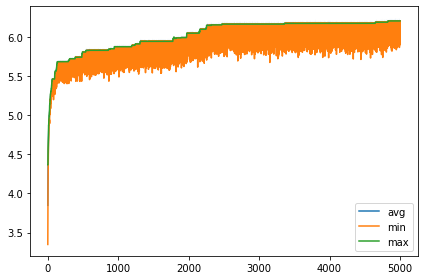

In [11]:
log = scenario.run()
draw_log(log)

## Modified version

In [19]:
class SimpleGAExperiment:
    def factory(self):
        return rnd.random(self.dimension) * 10 - 5

    def __init__(self, function, dimension, pop_size, iterations):
        self.pop_size = pop_size
        self.iterations = iterations
        self.mut_prob = 0.9
        self.cross_prob = 0.1

        self.function = function
        self.dimension = dimension

        # Parallelizing the execution of a function across multiple input values
        self.pool = Pool(8)

        self.toolbox = base.Toolbox()
        self.toolbox.register("map", self.pool.map)
        self.toolbox.register("individual", tools.initIterate, creator.Individual, self.factory)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual, self.pop_size)
        
        # Operators the usual names for the evolutionary tools are mate(), mutate(), evaluate()
        self.toolbox.register("mate", tools.cxOnePoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=1, sigma=1.5, indpb=0.02)
        self.toolbox.register("select", tools.selTournament, tournsize=4)
        self.toolbox.register("evaluate", self.function)


    def run(self):
        pop = self.toolbox.population()
        hof = tools.HallOfFame(3, np.array_equal)
        
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, log = algorithms.eaMuPlusLambda(
            pop, 
            self.toolbox, 
            mu=self.pop_size, 
            lambda_=int(self.pop_size*0.8), 
            cxpb=self.cross_prob, 
            mutpb=self.mut_prob,
            ngen=self.iterations,
            stats=stats, 
            halloffame=hof, 
            verbose=True,
        )

        print("Best = {}".format(hof[0]))
        print("Best fit = {}".format(hof[0].fitness.values[0]))
        return log

gen	nevals	avg    	std     	min    	max    
0  	100   	3.84518	0.171056	3.39768	4.27337
1  	80    	4.03157	0.129308	3.7738 	4.29789
2  	80    	4.17774	0.101043	3.96364	4.31926
3  	80    	4.26683	0.0482426	4.10994	4.34259
4  	80    	4.30433	0.0259621	4.25533	4.38291
5  	80    	4.3248 	0.0206478	4.2755 	4.38291
6  	80    	4.34618	0.0227729	4.28653	4.38844
7  	80    	4.37062	0.0159436	4.32105	4.39504
8  	80    	4.38343	0.00995633	4.35623	4.40431
9  	80    	4.39618	0.0128179 	4.38291	4.44472
10 	80    	4.41213	0.0178671 	4.38291	4.44472
11 	80    	4.43173	0.0162987 	4.40027	4.4659 
12 	80    	4.44684	0.016496  	4.40268	4.49475
13 	80    	4.46521	0.0188836 	4.40872	4.49475
14 	80    	4.48557	0.018484  	4.4488 	4.57366
15 	80    	4.5092 	0.024831  	4.4488 	4.55012
16 	80    	4.53221	0.0205282 	4.49475	4.55833
17 	80    	4.55175	0.0140647 	4.5028 	4.60043
18 	80    	4.56292	0.0147722 	4.54212	4.61798
19 	80    	4.57794	0.0163437 	4.54015	4.61923
20 	80    	4.59382	0.0160729 	4.54983	4.62284
2

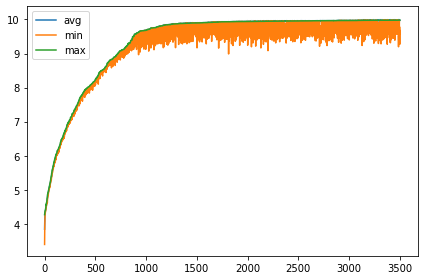

In [20]:
def function(x):
    res = rastrigin(x)
    return res,

dimension = 100 # set it to 100
pop_size = 100 # lets say max is 100
iterations = 3500 # lets say max is 5000
scenario = SimpleGAExperiment(function, dimension, pop_size, iterations)
log = scenario.run()
draw_log(log)

In [26]:
def read_log_plotly(log):
    avg_list, std_list, min_list, max_list, gen_list = list(), list(), list(), list(), list()

    for g in log:
        avg_list.append(g['avg'])
        std_list.append(g['std'])
        min_list.append(g['min'])
        max_list.append(g['max'])
        gen_list.append(g['gen'])
    
    return np.array(gen_list), np.array(avg_list), \
        np.array(std_list), np.array(max_list), \
        np.array(min_list)

def draw_log_plotly(log):
    gen_list, avg_list, std_list, max_list, min_list = read_log_plotly(log)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=gen_list, y=avg_list, mode='lines', name='avg'))
    fig.add_trace(go.Scatter(x=gen_list, y=min_list, mode='lines', name='min'))
    fig.add_trace(go.Scatter(x=gen_list, y=max_list, mode='lines', name='max'))
    
    fig.add_trace(go.Scatter(
        x=np.concatenate((gen_list, gen_list[::-1])),
        y=np.concatenate((avg_list-std_list, (avg_list+std_list)[::-1])),
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        name='std deviation'
    ))

    fig.update_layout(
        title='Log Plot',
        title_x=0.5,
        xaxis_title='Generation',
        yaxis_title='Values',
        legend=dict(x=0, y=1.1, traceorder='normal'),
        margin=dict(l=0, r=0, t=30, b=0),
        showlegend=True,
    )

    fig.show()


draw_log_plotly(log)

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/success.svg">
>   <img alt="Success" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/success.svg">
> </picture><br>
>
> 
> `Best fit = 9.979037236733662`